In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.spatial.distance import cdist
import sys
sys.path += ["../src"]
import config
import utils
from glob import glob
import gzip
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
import json
import ot
from jl_synthetic_pop_all_vae_provinces_airbnb import read_gz, read_json, get_df_city_for_nf

In [2]:
import pickle
from airbnb_all_baselines import from_cat_to_dummies_airbnb

In [3]:
airbnb_path = "/data/housing/data/intermediate/jl_pop_synth/airbnb/"

In [32]:
zero_std = {}
for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')):
    city = file.split(".")[-2].split("_")[-1]
    with open(file, 'rb') as f:
        data = pickle.load(f)
    
    for k in data:
        zero_std[k] = data[k].loc[:,data[k].std() < 0.01].columns
    

In [39]:
all_wsd = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')):

        city = file.split(".")[-2].split("_")[-1]
        with open(file, 'rb') as f:
                data = pickle.load(f)
        print(city)


        all_wsd[city] = {}

        for k in data:
                if "95" not in k:
                        wsd = ot.sliced_wasserstein_distance(data["df_real"][['x', 'y']].to_numpy(),
                               data[k][['x', 'y']].to_numpy(), 
                               n_projections = 1000)
                        all_wsd[city][k] = wsd
                        df_wsd = pd.DataFrame(all_wsd).T
                        df_wsd.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_wasserstein_geo_airbnb.csv")




austin
barcelona
brisbane
cape town
copenhagen
hawaii
hong-kong
lyon
mexico city
montreal
naples
paris
santiago
seattle
singapore
washington dc


In [ ]:
df_wsd = pd.DataFrame(all_wsd).T

In [ ]:
#df_wsd.to_csv(airbnb_path + "wasserstein_distances_airbnb_250825.csv")

df_wsd.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_wasserstein_geo_airbnb.csv")
df_wsd = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_wasserstein_geo_airbnb.csv", index_col = 0)
df_wsd = df_wsd.apply(lambda x: (x - x.mean()) / x.std(), axis = 1)

In [6]:
df_wsd.mean().sort_values()

df_real                         -0.965901
df_nf_copula                    -0.695852
df_nfvae                        -0.581859
df_shuffle_neighbourhood_num    -0.503472
df_shuffle_neighbourhood_bins   -0.498015
df_copula                       -0.302863
df_vae                           0.391557
df_shuffle_city_bins             1.574139
df_shuffle_city_num              1.582264
dtype: float64

<Axes: >

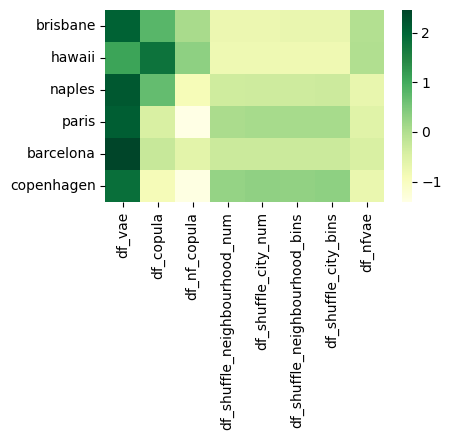

In [7]:
fig, axes = sbp(figsize = (4.5,2.5))

sns.heatmap(df_wsd, cmap = "YlGn")

<Axes: xlabel='distance', ylabel='method'>

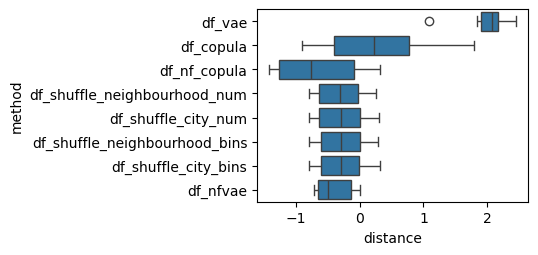

In [20]:
fig, axes = sbp(figsize = (3.5, 2.5))

sns.boxplot(data = df_wsd.stack().reset_index().rename(columns = {"level_1": "method", 0: "distance"}), x = "distance", y = "method")

### Geo vs Features

In [10]:
def get_df_bins(df_, df_real, bin_size = 0.01):
    df = df_.copy()

    bins_x = np.arange(df_real["x"].min() - bin_size / 2, df_real["x"].max() + bin_size / 2, bin_size)
    bins_y = np.arange(df_real["y"].min() - bin_size / 2, df_real["y"].max() + bin_size / 2, bin_size)

    df["bin_x"] = pd.cut(df["x"], bins = bins_x, labels = np.arange(len(bins_x)-1))
    df["bin_y"] = pd.cut(df["y"], bins = bins_y, labels = np.arange(len(bins_y)-1))
    df.drop(columns = ["x", "y"], inplace = True)

    return df


In [11]:
all_geo_features = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')):
    city = file.split(".")[-2].split("_")[-1]
    all_geo_features[city] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    df_real = get_df_bins(data["df_real"].copy(), data["df_real"])
    for k in data:
        if "95" not in k:
            df_k = get_df_bins(data[k], data["df_real"])
            dist = np.abs((df_real.groupby(["bin_x", "bin_y"]).mean() - df_k.groupby(["bin_x", "bin_y"]).mean()).dropna()).sum(axis = 1).mean()
            all_geo_features[city][k] = dist

            

In [ ]:
#df_geo_features = pd.DataFrame(all_geo_features).T
#df_geo_features.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_airbnb.csv")
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_airbnb.csv", index_col = 0)

df_geo_features = df_geo_features.apply(lambda x: (x - x.mean()) / (x.std() + 0.0001), axis = 1)

In [ ]:
df_geo_features.mean().sort_values()

,df_real,df_vae,df_copula,df_nf_copula,df_shuffle_neighbourhood_num,df_shuffle_city_num,df_shuffle_neighbourhood_bins,df_shuffle_city_bins,df_nfvae
austin,-2.559508,0.603358,0.001036,0.594488,-0.078137,0.060446,0.523379,0.629794,0.225145
barcelona,-1.683540,0.451297,-0.406321,-0.200767,-0.656636,-0.363303,1.090709,1.732638,0.035924
brisbane,-2.569171,0.503682,0.156452,0.171794,-0.082474,0.429497,0.099868,0.814583,0.475769
cape town,-2.483906,0.780708,0.032689,0.377715,-0.239004,0.177560,0.260202,0.947989,0.146046
copenhagen,-1.494666,0.100046,-0.205161,-0.215311,-0.641591,-0.635666,1.541686,1.572910,-0.022247
hawaii,-2.376632,0.022154,0.261222,-0.074348,-0.110365,0.154348,0.933311,1.170247,0.020063
hong-kong,-2.334424,1.022731,-0.174393,0.666636,-0.355518,0.410212,-0.226700,0.805281,0.186175
lyon,-2.332206,0.971620,-0.143209,0.058046,-0.318506,-0.267498,0.542571,0.656622,0.832561
mexico city,-2.117077,0.230749,-0.322308,0.098060,-0.289444,-0.148251,0.982359,1.508883,0.057028
montreal,-2.013499,1.289414,-0.403550,0.416707,-0.470787,-0.353217,0.571372,1.117889,-0.154329


<Axes: >

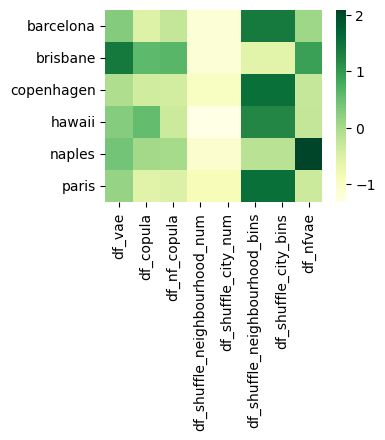

In [15]:
fig, axes = sbp(figsize = (3.5,2.5))

sns.heatmap(df_geo_features.T, cmap = "YlGn")

<Axes: xlabel='distance', ylabel='method'>

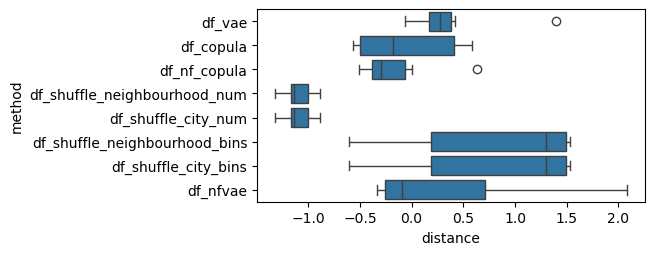

In [18]:
fig, axes = sbp(figsize = (5, 2.5))

sns.boxplot(data = df_geo_features.stack().reset_index().rename(columns = {"level_0": "method", 0: "distance"}), x = "distance", y = "method")

### Similarity PCA

In [15]:
from sklearn.decomposition import PCA

In [23]:
all_geo_features = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2].split("_")[-1]

    all_geo_features[prov] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)
    data = {k: data[k].reset_index(drop = True) for k in data}

    pca = PCA(n_components = 14)
    pca.fit(data["df_real"].drop(columns = ["x", "y"]))
    n_components95 = (pca.explained_variance_ratio_.cumsum() < .95).sum()


    data_pca = {k: pd.concat([data[k][["x", "y"]], pd.DataFrame(pca.transform(data[k].fillna(0).drop(columns = ["x", "y"]))[:,:n_components95])], axis = 1) for k in data if "95" not in k}
    df_real = get_df_bins(data_pca["df_real"].copy(), data_pca["df_real"])

    for k in data:
        if "95" not in k:
            df_k = get_df_bins(data_pca[k], data_pca["df_real"])
            dist = (np.abs((df_real.groupby(["bin_x", "bin_y"]).mean() - df_k.groupby(["bin_x", "bin_y"]).mean()).dropna()).mean() * pca.explained_variance_ratio_[:n_components95]).sum()
            all_geo_features[prov][k] = dist

            

In [24]:
df_geo_features = pd.DataFrame(all_geo_features)
df_geo_features.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_pca_airbnb.csv")
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_pca_airbnb.csv", index_col = 0)
#df_geo_features = df_geo_features.drop("df_real").apply(lambda x: (x - x.mean()) / (x.std() + 0.0001))


### Correlations

In [28]:
all_corrs_dist = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')):
    city = file.split(".")[-2].split("_")[-1]
    all_corrs_dist[city] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)
    corr_real = data["df_real"].drop(columns = ["x", "y"]).corr()

    for k in data:
        if "95" not in k:
            corr_k = data[k].drop(columns = ["x", "y"]).corr()
            dist = (np.abs(corr_real - corr_k)).sum().sum()
            all_corrs_dist[city][k] = dist

In [32]:
df_corr = pd.DataFrame(all_corrs_dist).T
df_corr.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_correlation_features_airbnb.csv")
df_corr = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_correlation_features_airbnb.csv", index_col = 0)


df_corr = df_corr.apply(lambda x: (x - x.mean()) / x.std(), axis = 1)

In [33]:
df_corr.mean().sort_values()

df_real                         -0.994508
df_shuffle_city_num             -0.904810
df_shuffle_neighbourhood_num    -0.904503
df_shuffle_city_bins            -0.668436
df_shuffle_neighbourhood_bins   -0.663296
df_vae                           0.862169
df_nfvae                         1.068042
df_copula                        1.093161
df_nf_copula                     1.112182
dtype: float64

<Axes: >

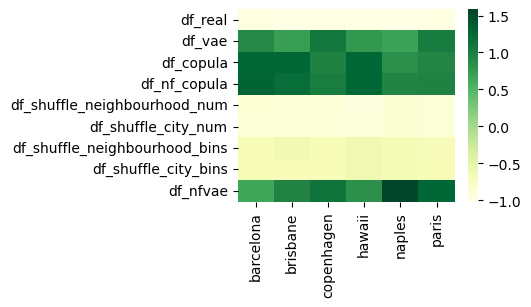

In [34]:
fig, axes = sbp(figsize = (3.5,2.5))

sns.heatmap(df_corr.T, cmap = "YlGn")

<Axes: xlabel='distance', ylabel='method'>

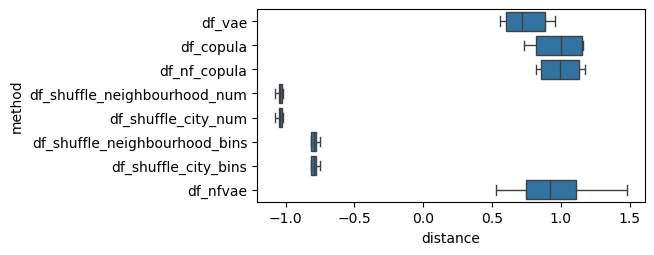

In [25]:
fig, axes = sbp(figsize = (5, 2.5))

sns.boxplot(data = df_corr.stack().reset_index().rename(columns = {"level_0": "method", 0: "distance"}), x = "distance", y = "method")

### Zero cell



In [ ]:
import geopandas as gpd
import pandas as pd
from glob import glob
import pickle
import numpy as np
import sys
sys.path += ["../src"]

In [ ]:
import utils
import jl_vae

geo_dict = jl_vae.load_geo_data()            

In [44]:
def get_neighbourhood_from_xy(df, gdf):
    df_geo = gpd.points_from_xy(df['x'], df['y'], z=None, crs="EPSG:3035")
    df_geo = df_geo.to_crs('EPSG:3035') #4326 3035
    if "neighbourhood" in df.columns:
        df_ = df.drop(columns = ["neighbourhood"]).copy()
    else:
        df_ = df.copy()
    df_gpd = gpd.GeoDataFrame(df_, geometry= df_geo)
    
    df_join = (gpd.tools.sjoin(df_gpd, gdf, 
                             predicate="within", how='left'))
    neighbourhood = df_join["neighbourhood"]
    
    return neighbourhood


In [ ]:
from jl_synthetic_ipf_all_provinces import *

In [40]:
def proportion_obs_houses(data, gdf):
    df_real = data["df_real"].copy()
    bins_rscore = pd.qcut(df_real["review_scores_rating"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_rmonth = pd.qcut(df_real["reviews_per_month"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_price = pd.qcut(df_real["log_price"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_rscore[0] = -np.inf
    bins_rscore[-1] = np.inf
    bins_rmonth[0] = -np.inf
    bins_rmonth[-1] = np.inf
    bins_price[0] = -np.inf
    bins_price[-1] = np.inf

    data_bins = {}
    for k in data:
        df_ = data[k].copy()
        df_["bin_rscore"] = pd.cut(df_["review_scores_rating"], bins = bins_rscore)
        df_["bin_rmonth"] = pd.cut(df_["reviews_per_month"], bins = bins_rmonth)
        df_["bin_price"] = pd.cut(df_["log_price"], bins = bins_price)
        neighbourhood = get_neighbourhood_from_xy(df_, gdf)

        df_["neighbourhood"] = neighbourhood
        df_.drop(columns = ["x", "y", "review_scores_rating", "reviews_per_month",  "log_price"], inplace = True)
        data_bins[k] = df_
    
    drop_cols = []
    df_real_list = [list(u) for _,u in data_bins["df_real"].drop(columns = drop_cols).iterrows()]
    in_real = {k: np.mean([list(data_bins[k].drop(columns = drop_cols).iloc[u,:]) in df_real_list for u in range(len(data_bins[k]))]) for k in data_bins}
    return in_real


In [42]:
all_zero_cell = {}


for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')):
    city = file.split(".")[-2].split("_")[-1]
    print(city)
    all_geo_features[city] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    data = {k: data[k] for k in data if "95" not in k}
    gdf = read_json(city)

    prop_obs_prov = proportion_obs_houses(data, gdf)
    all_zero_cell[prov] = prop_obs_prov
    zero_cell_df = pd.DataFrame(all_zero_cell)
    zero_cell_df.to_csv(f'/data/housing/data/intermediate/jl_pop_synth/zero_cell_airbnb.csv')



barcelona


KeyboardInterrupt: 

In [45]:
get_neighbourhood_from_xy(data["df_copula"], gdf)

8249                       el Fort Pienc
52040                 la Sagrada Família
38801                         la Sagrera
4403          el Camp de l'Arpa del Clot
40748                          les Corts
                      ...               
25089                        el Poblenou
14082                 la Sagrada Família
23116                       el Poble Sec
40007                        el Guinardó
8890     l'Antiga Esquerra de l'Eixample
Name: neighbourhood, Length: 11377, dtype: object

### Utility

In [46]:
from pyfixest.estimation import feols


In [ ]:
def lr_price(df):
    vars = df.drop(columns = ["x", "y", "log_price"]).columns
    eq_regr_price = f'log_price ~ {" + ".join(list(vars))}'
    
    reg_price = feols(fml = eq_regr_price, data = df, drop_intercept = False)

    return reg_price 

In [86]:
all_corr_coefs = {}
all_r2 = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')):
    city = file.split(".")[-2].split("_")[-1]
    print(city)
    all_corr_coefs[city] = {}
    all_r2[city] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    all_corr_coefs[city] = {}
    all_r2[city] = {}

    for k in data:
        df = data[k].copy()
        df_real = data["df_real"].copy()
        df.columns = [u.replace(" ", "_").replace("/", "_").replace("-", "_") for u in df.columns]
        df_real.columns = [u.replace(" ", "_").replace("/", "_").replace("-", "_") for u in df_real.columns]
    
        if "95" not in k:
            try:
                lr_prov = lr_price(df)
                coef_k = lr_prov.coef()
                all_corr_coefs[city][k] = coef_k
                all_r2[city][k] = np.corrcoef(lr_prov.predict(df_real.drop(columns = ["log_price", "x", "y"])), df_real["log_price"])[1,0] ** 2
            except Exception as e:
                print(e)
                all_corr_coefs[city][k] = None
                all_r2[city][k] = None

            

barcelona
brisbane
copenhagen
hawaii
naples
paris


In [88]:
df_corr_coefs = pd.DataFrame({city: pd.DataFrame(all_corr_coefs[city]).corr().iloc[0] for city in all_corr_coefs}).T
df_r2 = pd.DataFrame(all_r2).T

In [ ]:
#df_r2.to_csv(f'/data/housing/data/intermediate/jl_pop_synth/utility_r2_regression_vs_real_price_airbnb.csv')